# Train the Models for some/all your datasets

### First just run the cell below, it should hopefully complete without error (expect some Warnings from TF)

In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2


#load some packages in
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import random as python_random
from numba import njit
from tensorboard.plugins.hparams import api as hp
from stemutils.io import Path
import hyperspy.api as hs
import concurrent.futures
from skimage.transform import resize
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from functools import lru_cache
from stemseg.processing_funcs import *

#set some variables
print('Using TensorFlow v%s' % tf.__version__)
plt.style.use('default')


#define some functions

###################################################
########### Data Preprocessing ####################
###################################################

def batch_resize(d, bs=512):
    if len(d.shape) == 4:
        flat_d = flatten_nav(d)
    else:
        flat_d = d
    n_batches = int(np.ceil(flat_d.shape[0]//bs))
    batches = [flat_d[i*bs:(i+1)*bs] for i in range(n_batches+1)]
    if len(batches[-1])==0:
        batches.pop(-1)
    print(len(batches[-1]))
    with concurrent.futures.ProcessPoolExecutor(max_workers=4) as exe:
        res = [exe.submit(resize, batch, (batch.shape[0],128,128)) for batch in batches]
    r_batches = [f.result() for f in res]
    return np.concatenate(r_batches, axis = 0).reshape((d.shape[0],128,128))

def data_manip(d, bs = 512):
    if type(d) != np.ndarray:
        print('dask to numpy')
        d = d.compute()
        print('dask to numpy done')
    print('started data manipulations')
    #d = resize(d,(d.shape[0],128,128))
    print('resized')
    d = d.astype('float32')
    for i in range(d.shape[0]):
        d_max = np.max(d[i])
        d[i] = d[i]/d_max
    d = batch_resize(d, bs)
    scaler = np.log(1001)
    return np.log((d*1000)+1)/scaler 


def data_manip_lowq(d, central_box = 128):
    pxc, pyc = d.shape[1]//2, d.shape[2]//2 
    pxl, pxu = pxc - central_box//2, pxc + central_box//2 
    pyl, pyu = pyc - central_box//2, pyc + central_box//2 
    
    d = d[:, pxl:pxu, pyl:pyu]
    if type(d) != np.ndarray:
        print('dask to numpy')
        d = d.compute()
        print('dask to numpy done')
    print('started data manipulations')
    #d = resize(d,(d.shape[0],128,128))
    print('resized')
    d = d.astype('float32')
    for i in range(d.shape[0]):
        d_max = np.max(d[i])
        d[i] = d[i]/d_max
    
    scaler = np.log(1001)
    return np.log((d*1000)+1)/scaler 


###################################################
###################################################
###################################################

def flatten_nav(sig):
    shape = [sig.shape[0]*sig.shape[1]]
    for i in sig.shape[2:]:
        shape.append(i)
    return sig.reshape(shape)


class My_Custom_Generator(keras.utils.Sequence) :
    def __init__(self, image_filenames,  batch_size) :
        self.image_filenames = image_filenames
        self.batch_size = batch_size

    def __len__(self) :
        return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(np.int)
    
    
    @lru_cache(None)
    def __getitem__(self, idx) :
        batch_x = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
        out_img = np.asarray([np.load(file_name)[:,:,None] for file_name in batch_x])
        return out_img, out_img
        #return batch_x, batch_y
        
        
class Array_Generator(keras.utils.Sequence) :
    def __init__(self, images,  batch_size, target = 'same') :
        self.images = images
        self.batch_size = batch_size
        if target == 'same':
            self.target = images
        else:
            self.target = target

    def __len__(self) :
        return (np.ceil(len(self.images) / float(self.batch_size))).astype(np.int)
    
    
    @lru_cache(None)
    def __getitem__(self, idx) :
        out_img = self.images[idx * self.batch_size : (idx+1) * self.batch_size, :,:,None]
        out_targ = self.target[idx * self.batch_size : (idx+1) * self.batch_size, :,:,None]
        return out_img, out_targ
        #return batch_x, batch_y

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.keras.backend.random_normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    
def create_vae_model(hparams):
    
    n_img = 128
    latent_dim = hparams['LAT']
    beta = hparams['B']

    image_input = keras.Input(shape=(n_img, n_img,1), name = 'enc_input')
    x = layers.Conv2D(hparams['KN1'],5, strides = 2, activation='relu',padding='same', input_shape=image_input.shape, name = 'enc_conv1')(image_input)
    x = layers.Conv2D(hparams['KN2'],5, strides = 2, activation='relu',padding='same', name = 'enc_conv2')(x)
    x = layers.Conv2D(hparams['KN3'],5, strides = 2, activation='relu',padding='same', name = 'enc_conv3')(x)
    x = layers.Conv2D(hparams['KN4'],5, strides = 2, activation='relu',padding='same', name = 'enc_conv4')(x)
    x = layers.Conv2D(hparams['KN5'],5, strides = 2, activation='relu',padding='same', name = 'enc_conv5')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(hparams['D1'], activation='relu', name = 'enc_d1')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'enc_d2_t')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'enc_d3_t')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'enc_d4_t')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'enc_d5_t')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'enc_d6_t')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'enc_d7_t')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'enc_d8_t')(x)
    z_mean = layers.Dense(latent_dim, name="z_mean_t")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var_t")(x)
    z_output = Sampling()([z_mean, z_log_var])
    encoder_VAE = keras.Model(image_input, [z_mean, z_log_var, z_output])

    z_input = keras.Input(shape=(latent_dim,), name = 'dec_input_t')
    x = layers.Dense(hparams['D2'], activation="relu", name = 'dec_d1_t')(z_input)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'dec_d2')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'dec_d3')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'dec_d4')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'dec_d5')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'dec_d6')(x)
    x = layers.Dense(hparams['D1'], activation="relu", name = 'dec_d7')(x)
    x = layers.Dense(4*4*hparams['KN5'], activation="relu", name = 'dec_d8')(x)
    x = layers.Reshape((4, 4,hparams['KN5']))(x)
    x = layers.Conv2DTranspose(hparams['KN4'],5, strides = 2, activation='relu',padding='same', name = 'dec_conv1')(x)
    x = layers.Conv2DTranspose(hparams['KN3'],5, strides = 2, activation='relu',padding='same', name = 'dec_conv2')(x)
    x = layers.Conv2DTranspose(hparams['KN2'],5, strides = 2, activation='relu',padding='same', name = 'dec_conv3')(x)
    x = layers.Conv2DTranspose(hparams['KN1'],5, strides = 2, activation='relu',padding='same', name = 'dec_conv4')(x)
    image_output = layers.Conv2DTranspose(1,5, strides = 2, activation='sigmoid',padding='same', name = 'dec_conv5')(x)
    #image_output = layers.Conv2DTranspose(16,3, strides = 2, activation='sigmoid',padding='same')
    #image_output = layers.Reshape((n_img, n_img,1))(x)
    decoder_VAE = keras.Model(z_input, image_output)

    # VAE class
    class VAE(keras.Model):
        # constructor
        def __init__(self, encoder, decoder, **kwargs):
            super(VAE, self).__init__(**kwargs)
            self.encoder = encoder
            self.decoder = decoder

        # customise train_step() to implement the loss 
        def train_step(self, x):
            if isinstance(x, tuple):
                x = x[0]
            with tf.GradientTape() as tape:
                # encoding
                z_mean, z_log_var, z = self.encoder(x)
                # decoding
                x_prime = self.decoder(z)
                # reconstruction error by binary crossentropy loss
                reconstruction_loss = tf.reduce_mean(keras.losses.binary_crossentropy(x, x_prime)) * n_img * n_img
                # KL divergence
                kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
                # loss = reconstruction error + KL divergence
                loss = reconstruction_loss + beta* kl_loss
            # apply gradient
            grads = tape.gradient(loss, self.trainable_weights)
            self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
            # return loss for metrics log
            return {"loss": loss}


        def call(self, x):
            if isinstance(x, tuple):
                x = x[0]
            # encoding
            z_mean, z_log_var, z = self.encoder(x)
            # decoding
            x_prime = self.decoder(z)
            return x_prime
    # build the VAE
    vae_model = VAE(encoder_VAE, decoder_VAE)

    # compile the VAE
    vae_model.compile(optimizer=keras.optimizers.Adam(learning_rate=hparams['LR']),loss=custom_loss)
    vae_model.build((1,128,128,1))
    
    return vae_model



def custom_loss(x,y):
    n_img = 128
    return tf.reduce_mean(keras.losses.binary_crossentropy(x, y)) * n_img * n_img


2022-05-04 14:43:52.329762: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
/dls_sw/apps/python/anaconda/4.6.14/64/envs/epsic3.7/lib/python3.7/site-packages/pyUSID/viz/__init__.py:18: FutureWarning: Please use sidpy.viz.plot_utils instead of pyUSID.viz.plot_utils. pyUSID.plot_utils will be removed in a future release of pyUSID
  FutureWarning)


Using TensorFlow v2.3.0
Using TensorFlow v2.3.0


### Now check that you can find the GPU

In [2]:
tf.config.list_physical_devices()

2022-05-04 14:44:12.247161: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

2022-05-04 14:44:12.248305: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:d8:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-05-04 14:44:12.248331: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-05-04 14:44:12.258050: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-05-04 14:44:12.263581: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2022-05-04 14:44:12.267083: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcurand.so.10
2022-05-04 14:44:12.272197: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcusolv

# Training a Single Dataset

### Either enter the path directly to the dp variable or use the index from the list above

In [3]:
#Either
dp = Path('/dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/SimulatedData/SimulatedDSA-data.hdf5')

### Create a directory to save our intermediate model checkpoints 

In [4]:
mp = dp.redirect('FullModel')
if not mp.exists():
    mp.mkdir()
print(mp)

/dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/SimulatedData/FullModel


### Load in the Data

In [5]:
sample = ProcessedSample(dp, 'Test')

### Create a dictionary to hold some useful information

In [6]:
info = {}

In [7]:
nds = flatten_nav(sample.raw_data.data)

In [8]:
nds.shape

(87320, 128, 128)

In [9]:
input_data = data_manip_lowq(nds)
np.random.shuffle(input_data)
input_targets = input_data
val_data = data_manip_lowq(nds)
np.random.shuffle(val_data)


dask to numpy
dask to numpy done
started data manipulations
resized
dask to numpy
dask to numpy done
started data manipulations
resized


<IPython.core.display.Javascript object>


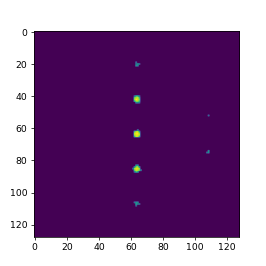

<IPython.core.display.Javascript object>


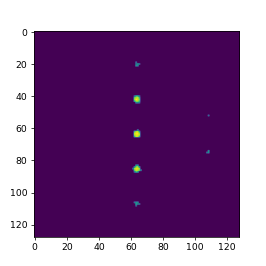

In [10]:
rand_patt = np.random.randint(0, len(input_data))
plt.figure(figsize = (4,4))
plt.imshow(input_data[rand_patt])
plt.figure(figsize = (4,4))
plt.imshow(input_targets[rand_patt])

##### Otherwise just skip

In [11]:
print(input_data.shape)

(87320, 128, 128)


In [12]:
batch_size = 2048

train_gen = Array_Generator(input_data, batch_size, target = input_targets)
valid_gen = Array_Generator(val_data, batch_size)

batch_shape = train_gen[0][0].shape
input_shape = (batch_shape[1],batch_shape[2],batch_shape[3])
out_dims = int(train_gen[0][1].shape[1])

### Check the training data

<IPython.core.display.Javascript object>


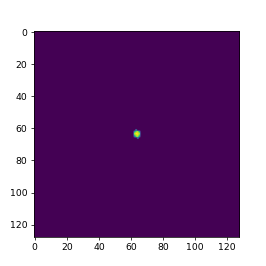

<IPython.core.display.Javascript object>


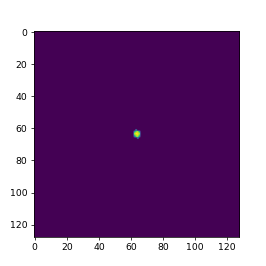

In [13]:
rand_patt = np.random.randint(0, len(input_data))
plt.figure(figsize = (4,4))
plt.imshow(input_data[rand_patt])
plt.figure(figsize = (4,4))
plt.imshow(input_targets[rand_patt])

### Set the checkpointing

In [14]:
chkpoint_filepath = str(mp)+'/chk-{epoch:02d}-{val_loss:.5e}.hdf5'
chkpoint_model = tf.keras.callbacks.ModelCheckpoint(
    filepath = chkpoint_filepath,
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode="min",
    save_freq="epoch",
    options=None)

### Redefine the model parameters if you want

In [15]:
rebin_factor = 1

In [16]:
sample_name = 'full'
hparams= {'KN1':32,'KN2':64,'KN3':128, 'KN4':128, 'KN5':256,'D1':128,'D2':512,'LAT':2,'LR':0.0001, 'B':1}

vae_model = create_vae_model(hparams)
info[sample_name] = {'rebin': rebin_factor, 'hparams':hparams}

2022-05-04 14:45:00.985869: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-04 14:45:00.997209: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2400000000 Hz
2022-05-04 14:45:01.001899: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55ee7f431350 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-05-04 14:45:01.001933: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-05-04 14:45:01.122722: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55ee7f49deb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-05-04 14:45:01.

### Will be helpful to start with a trained model so set one here (otherwise will just take longer)

In [ ]:
old_model ='/dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/SimulatedData/FullModel/chk-57-5.16417e+01.hdf5'

In [ ]:
vae_model.load_weights(old_model)

### Train the Model

In [17]:
history = vae_model.fit(train_gen, validation_data=valid_gen, epochs=1000, callbacks= [chkpoint_model])

Epoch 1/1000


2022-05-04 14:45:04.500726: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-05-04 14:45:04.755016: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7
2022-05-04 14:45:05.770032: W tensorflow/stream_executor/gpu/asm_compiler.cc:81] Running ptxas --version returned 256
2022-05-04 14:45:05.870136: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


43/43 [==============================] - ETA: 0s - loss: 8504.3967WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0520s vs `on_test_batch_end` time: 0.1855s). Check your callbacks.



Epoch 00001: val_loss improved from inf to 1308.64673, saving model to /dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/SimulatedData/FullModel/chk-01-1.30865e+03.hdf5
43/43 [==============================] - 49s 1s/step - loss: 8341.8408 - val_loss: 1308.6467
Epoch 2/1000
43/43 [==============================] - ETA: 0s - loss: 921.6737
Epoch 00002: val_loss improved from 1308.64673 to 614.54443, saving model to /dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/SimulatedData/FullModel/chk-02-6.14544e+02.hdf5
43/43 [==============================] - 33s 761ms/step - loss: 914.8615 - val_loss: 614.5444
Epoch 3/1000
43/43 [==============================] - ETA: 0s - loss: 426.8623
Epoch 00003: val_loss improved from 614.54443 to 263.58963, saving model to /dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/SimulatedData/FullModel/chk-03-2.63590e+02.hdf5
43/43 [==============================] - 33s 768ms/step - loss: 423.1131 - v

Epoch 24/1000
43/43 [==============================] - ETA: 0s - loss: 82.2213
Epoch 00024: val_loss improved from 80.60086 to 80.42741, saving model to /dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/SimulatedData/FullModel/chk-24-8.04274e+01.hdf5
43/43 [==============================] - 33s 774ms/step - loss: 82.1306 - val_loss: 80.4274
Epoch 25/1000
43/43 [==============================] - ETA: 0s - loss: 82.5208
Epoch 00025: val_loss did not improve from 80.42741
43/43 [==============================] - 33s 770ms/step - loss: 82.5312 - val_loss: 80.5932
Epoch 26/1000
43/43 [==============================] - ETA: 0s - loss: 82.0399
Epoch 00026: val_loss improved from 80.42741 to 80.27576, saving model to /dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/SimulatedData/FullModel/chk-26-8.02758e+01.hdf5
43/43 [==============================] - 33s 774ms/step - loss: 81.9439 - val_loss: 80.2758
Epoch 27/1000
43/43 [==============================

Epoch 48/1000
43/43 [==============================] - ETA: 0s - loss: 61.2353
Epoch 00048: val_loss improved from 60.69772 to 59.04817, saving model to /dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/SimulatedData/FullModel/chk-48-5.90482e+01.hdf5
43/43 [==============================] - 33s 770ms/step - loss: 61.1493 - val_loss: 59.0482
Epoch 49/1000
43/43 [==============================] - ETA: 0s - loss: 60.5332
Epoch 00049: val_loss did not improve from 59.04817
43/43 [==============================] - 33s 766ms/step - loss: 60.5551 - val_loss: 60.6664
Epoch 50/1000
43/43 [==============================] - ETA: 0s - loss: 59.7219
Epoch 00050: val_loss improved from 59.04817 to 57.96992, saving model to /dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/SimulatedData/FullModel/chk-50-5.79699e+01.hdf5
43/43 [==============================] - 33s 769ms/step - loss: 59.8113 - val_loss: 57.9699
Epoch 51/1000
43/43 [==============================

43/43 [==============================] - ETA: 0s - loss: 62.9383
Epoch 00075: val_loss did not improve from 47.35655
43/43 [==============================] - 33s 769ms/step - loss: 62.8908 - val_loss: 58.7166
Epoch 76/1000
43/43 [==============================] - ETA: 0s - loss: 58.6633
Epoch 00076: val_loss did not improve from 47.35655
43/43 [==============================] - 33s 765ms/step - loss: 58.6477 - val_loss: 55.7457
Epoch 77/1000
43/43 [==============================] - ETA: 0s - loss: 56.2475
Epoch 00077: val_loss did not improve from 47.35655
43/43 [==============================] - 33s 768ms/step - loss: 56.2049 - val_loss: 53.7889
Epoch 78/1000
43/43 [==============================] - ETA: 0s - loss: 54.5250
Epoch 00078: val_loss did not improve from 47.35655
43/43 [==============================] - 33s 766ms/step - loss: 54.5461 - val_loss: 52.4199
Epoch 79/1000
43/43 [==============================] - ETA: 0s - loss: 53.2814
Epoch 00079: val_loss did not improve from 

43/43 [==============================] - ETA: 0s - loss: 46.8693
Epoch 00104: val_loss improved from 45.38226 to 45.26889, saving model to /dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/SimulatedData/FullModel/chk-104-4.52689e+01.hdf5
43/43 [==============================] - 33s 769ms/step - loss: 46.9041 - val_loss: 45.2689
Epoch 105/1000
43/43 [==============================] - ETA: 0s - loss: 46.7123
Epoch 00105: val_loss improved from 45.26889 to 45.15963, saving model to /dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/SimulatedData/FullModel/chk-105-4.51596e+01.hdf5
43/43 [==============================] - 33s 769ms/step - loss: 46.6888 - val_loss: 45.1596
Epoch 106/1000
43/43 [==============================] - ETA: 0s - loss: 46.5912
Epoch 00106: val_loss improved from 45.15963 to 45.06618, saving model to /dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/SimulatedData/FullModel/chk-106-4.50662e+01.hdf5
43/43 [=====

Epoch 130/1000
43/43 [==============================] - ETA: 0s - loss: 48.7644
Epoch 00130: val_loss did not improve from 44.20877
43/43 [==============================] - 33s 769ms/step - loss: 48.7887 - val_loss: 46.3624
Epoch 131/1000
43/43 [==============================] - ETA: 0s - loss: 47.1976
Epoch 00131: val_loss did not improve from 44.20877
43/43 [==============================] - 33s 770ms/step - loss: 47.1875 - val_loss: 45.2539
Epoch 132/1000
43/43 [==============================] - ETA: 0s - loss: 46.4933
Epoch 00132: val_loss did not improve from 44.20877
43/43 [==============================] - 33s 767ms/step - loss: 46.4919 - val_loss: 44.8214
Epoch 133/1000
43/43 [==============================] - ETA: 0s - loss: 46.1996
Epoch 00133: val_loss did not improve from 44.20877
43/43 [==============================] - 33s 769ms/step - loss: 46.2344 - val_loss: 44.6602
Epoch 134/1000
43/43 [==============================] - ETA: 0s - loss: 46.0469
Epoch 00134: val_loss di

Epoch 162/1000
43/43 [==============================] - ETA: 0s - loss: 45.3356
Epoch 00162: val_loss did not improve from 43.94953
43/43 [==============================] - 33s 766ms/step - loss: 45.3778 - val_loss: 44.0143
Epoch 163/1000
43/43 [==============================] - ETA: 0s - loss: 45.3180
Epoch 00163: val_loss did not improve from 43.94953
43/43 [==============================] - 33s 768ms/step - loss: 45.3486 - val_loss: 43.9900
Epoch 164/1000
43/43 [==============================] - ETA: 0s - loss: 45.2856
Epoch 00164: val_loss did not improve from 43.94953
43/43 [==============================] - 33s 770ms/step - loss: 45.3082 - val_loss: 43.9701
Epoch 165/1000
43/43 [==============================] - ETA: 0s - loss: 45.2617
Epoch 00165: val_loss did not improve from 43.94953
43/43 [==============================] - 33s 770ms/step - loss: 45.2556 - val_loss: 43.9845
Epoch 166/1000
43/43 [==============================] - ETA: 0s - loss: 45.2698
Epoch 00166: val_loss di

Epoch 194/1000
43/43 [==============================] - ETA: 0s - loss: 51.7460
Epoch 00194: val_loss did not improve from 43.76631
43/43 [==============================] - 33s 769ms/step - loss: 51.6443 - val_loss: 48.9521
Epoch 195/1000
43/43 [==============================] - ETA: 0s - loss: 49.4134
Epoch 00195: val_loss did not improve from 43.76631
43/43 [==============================] - 33s 768ms/step - loss: 49.3706 - val_loss: 47.2644
Epoch 196/1000
43/43 [==============================] - ETA: 0s - loss: 48.1201
Epoch 00196: val_loss did not improve from 43.76631
43/43 [==============================] - 33s 769ms/step - loss: 48.1227 - val_loss: 46.3131
Epoch 197/1000
43/43 [==============================] - ETA: 0s - loss: 47.3620
Epoch 00197: val_loss did not improve from 43.76631
43/43 [==============================] - 33s 768ms/step - loss: 47.3063 - val_loss: 45.6940
Epoch 198/1000
43/43 [==============================] - ETA: 0s - loss: 46.9193
Epoch 00198: val_loss di

KeyboardInterrupt: 

In [445]:
vae_model.save_weights('/dls/science/groups/imaging/ePSIC_students/Al_alloy_4DSTEM_EM19064-2/FullModel/ntest6.hdf5')

### If the training has exitted correctly you can delete the intermediate checkpoints

In [41]:
cps = mp.walk('.hdf5')
best_model_ind = np.asarray([float(str(i).split('-')[-1].split('.hd')[0]) for i in cps]).argmin()
best_model = cps[best_model_ind]

In [ ]:
for x, mod in enumerate(cps):
    if x != best_model_ind:
        mod.unlink()
print('cleared')

### You can then resave this model in a different folder along with the model architecture information

In [37]:
final_path = Path('/'.join(str(mp).split('/')[:-1]) + '/Final_Models')

if not final_path.exists():
    final_path.mkdir()

In [42]:
vae_model.load_weights(best_model)

new_name = str(final_path) + f'/{sample_name}_resampled_unbinned_model.hdf5'

best_model.rename(new_name)

In [38]:
import json

with open(f'{final_path}/{sample_name}_info.json', 'w') as f:
    json.dump(info, f)

In [43]:
new_name

'/dls/e02/data/2021/mg28749-1/processing/Calibrated/20210925_152115/Final_Models/full_resampled_unbinned_model.hdf5'

### Done

# If you want to train them all sequentially this for loop should work the same as above

In [ ]:
import time

dp = Path('/dls/e02/data/2021/mg28749-1/processing/Calibrated')

dl = dp.ls()
dl

#set your starting pretrained model here - each subsequent model will retrain off the previous
new_name = '/dls/e02/data/2021/mg28749-1/processing/Calibrated/20210925_123232/Final_Models/full_3bin_best_model.hdf5'

for select in range(31, len(dl)):
    dp = dl[select].walk('.hdf5', 'Model')[0]

    mp = Path('/'.join(str(dp).split('/')[:-1])+'/CropModel')
    if not mp.exists():
        mp.mkdir()

    ds = hs.load(dp)
    s = ds.data.shape

    info = {}

    rebin_factor = 3

    ds = ds.rebin(None, [rebin_factor,rebin_factor,1,1])

    ds.data = ds.data/(rebin_factor*rebin_factor)


    input_data = data_manip(flatten_nav(ds.data))
    filenames_shuffled = [x for x in shuffle(input_data,input_data)]
    filenames_shuffled_numpy = np.array(filenames_shuffled[0])
    labels_shuffled_numpy = np.array(filenames_shuffled[1])

    X_train, X_val, Y_train, Y_val = filenames_shuffled_numpy, labels_shuffled_numpy, filenames_shuffled_numpy, labels_shuffled_numpy
    print(X_train.shape) # (3800,)
    print(Y_train.shape)           # (3800, 12)

    print(X_val.shape)   # (950,)
    print(Y_val.shape)             # (950, 12)

    batch_size = 1024

    train_gen = Array_Generator(X_train, batch_size)
    valid_gen = Array_Generator(X_val, batch_size)

    batch_shape = train_gen[0][0].shape
    input_shape = (batch_shape[1],batch_shape[2],batch_shape[3])
    out_dims = int(train_gen[0][1].shape[1])

    chkpoint_filepath = str(mp)+'/chk-{epoch:02d}-{val_loss:.5e}.hdf5'
    chkpoint_model = tf.keras.callbacks.ModelCheckpoint(
        filepath = chkpoint_filepath,
        monitor="val_loss",
        verbose=1,
        save_best_only=True,
        save_weights_only=True,
        mode="min",
        save_freq="epoch",
        options=None)


    hparams= {'KN1':32,'KN2':64,'KN3':128, 'KN4':128, 'KN5':256,'D1':128,'D2':512,'LAT':2,'LR':0.00001, 'B':1}

    vae_model = create_vae_model(hparams)

    sample_name = 'full_3bin'
    info[sample_name] = {'rebin': rebin_factor, 'hparams':hparams}
    #info[sample_name] = {'cxl':cxl, 'cxu':cxu,'cyl':cyl, 'cyu': cyu, 'rebin': rebin_factor, 'hparams':hparams}

    vae_model.load_weights(new_name)

    history = vae_model.fit(train_gen, validation_data=valid_gen, epochs=2000, callbacks= [chkpoint_model])
    print('get cps')
    cps = mp.walk('.hdf5')
    best_model_ind = np.asarray([float(str(i).split('-')[-1].split('.hd')[0]) for i in cps]).argmin()
    best_model = cps[best_model_ind]
    for x, mod in enumerate(cps):
        if x != best_model_ind:
            mod.unlink()
    print('cleared')

    vae_model.load_weights(best_model)

    final_path = Path('/'.join(str(mp).split('/')[:-1]) + '/Final_Models')

    if not final_path.exists():
        final_path.mkdir()

    new_name = str(final_path) + f'/{sample_name}_best_model.hdf5'

    best_model.rename(new_name)

    import json

    with open(f'{final_path}/{sample_name}_info.json', 'w') as f:
        json.dump(info, f)
        
    input_data = None
    filenames_shuffled = None
    filenames_shuffled_numpy = None
    labels_shuffled_numpy = None

    X_train, X_val, Y_train, Y_val = None, None, None, None
    input_data = None
    train_gen = None
    valid_gen = None
    vae_model = None
    history = None
    
    time.sleep(10)
    print('next')

Using TensorFlow v2.3.0
